In [1]:
from lstd import *
from q_learning import *
import numpy as np
from typing import List, Tuple
from utils import *
from itertools import product

># Model Definition

In [2]:
THETA   = 1/2
KAPPA   = 1/2
OMEGA_A = 0.1
OMEGA_U = 0.1
GAMMA_U = 0.9
BETA_U  = 0.1 
BETA_A  = 0.1 
ALPHA_U = 1
SIGMA_D = 1
LAMBDA  = 1

In [3]:
A = np.array([
        [1, 0, 0, 0, 0],
        [0, 0, 0, 1, 1],
        [0, 0, 0, THETA, THETA - KAPPA],
        [0, 0, 0, 1 - OMEGA_A, 0],
        [0, 0, 0, 0, 1 - OMEGA_U]])
B = np.array([1, GAMMA_U, (THETA - KAPPA) * GAMMA_U, 0, OMEGA_U * BETA_U])

Sigma_x = np.array([
    [0, 0, 0, 0, 0], 
    [0, SIGMA_D**2, THETA*SIGMA_D**2, 0, 0],
    [0, THETA*SIGMA_D**2, THETA**2*SIGMA_D**2, 0, 0],
    [0, 0, 0, BETA_A**2, 0],
    [0, 0, 0, 0, 0]])



Q = np.array([
    [LAMBDA*SIGMA_D**2, 0, 0, -1/2, -1/2], 
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [-1/2, 0, 0, 0, 0],
    [-1/2, 0, 0, 0, 0]])
S = np.array([
    [LAMBDA*THETA*SIGMA_D**2 - GAMMA_U/2, 0, 0, -THETA/2, -(THETA - KAPPA)/2]])

R = np.array([[LAMBDA*THETA**2*SIGMA_D**2 - (THETA - KAPPA)*GAMMA_U]])
C = np.array([[1,0,0,0,0],[0,1,0,0,0],[0,0,1,0,0],[0,0,0,1,0]])
L = np.block([[Q, S.T], [S, R]])

We will re-utilize the LQR gain obtained previously

In [4]:
K_star = np.array([0.85724945,  0.,          0.,         -0.40135333, -0.38022947])

># Prerequisite

We first define the helper functions

In [5]:
def LQR_policy(x: np.ndarray) -> np.ndarray:
    return -K_star @ x

In [6]:
def simulate_linear_model(x0: np.ndarray, policy : callable, n_step : int, with_noise : bool = False) -> Tuple[np.ndarray, np.ndarray]:

    x = np.zeros((5, n_step))
    u = np.zeros((1, n_step-1))

    x[:,0] = x0

    for i in range(n_step-1):

        u[:, i] = policy(x[:,i])
        
        if with_noise:
            x[:,i+1] = A @ x[:,i] + B * u[:, i] + np.random.multivariate_normal(np.zeros(5), Sigma_x)
        else:
            x[:,i+1] = A @ x[:,i] + B * u[:, i]

    return (x, u)


def simulate_nl_model(x0: np.ndarray, policy : callable, n_step : int, with_noise : bool = False) -> Tuple[np.ndarray, np.ndarray]:

    x = np.zeros((5, n_step))
    u = np.zeros((1, n_step-1))

    x[:,0] = x0

    for i in range(n_step-1):

        I = x[0,i]
        x_a = x[3,i]
        x_u = x[4,i]

        # Control input based on the LQG controller
        u[:, i] = policy(x[:, i])
     
        # Update state 
        F = np.array([
            I + u[0, i],
            x_a + x_u + GAMMA_U* u[0, i] + ALPHA_U * u[0, i] * x_u,
            THETA * x_a + (THETA - KAPPA) * x_u + (THETA - KAPPA) * GAMMA_U * u[0, i] + (THETA - KAPPA) * ALPHA_U * u[0, i] * x_u,
            (1 - OMEGA_A) * x_a,
            (1 - OMEGA_U) * x_u + OMEGA_U * BETA_U * u[0, i]
        ])

        if with_noise:
            xi_d = np.random.normal(0, 1)
            xi_a = np.random.normal(0, 1)

            xi = np.array([0, SIGMA_D*xi_d, THETA*SIGMA_D*xi_d, BETA_A*xi_a, 0]).reshape(-1)

            x[:, i+1] = F + xi
        else:
            x[:, i+1] = F

    return (x, u)

We generate the data :

In [7]:
n_step = 1000

x0 = [[5, 2, 2, 2, 0]]#, [0, 2, 2, 2, 5], [5, 2, 2, 2, 5], [0, 2, 2, 2, 0]]

x_traj_linear = []
u_traj_linear = []

x_traj_nl = []
u_traj_nl = []

for x0_i in x0:

    x_traj_i, u_traj_i = simulate_linear_model(x0_i, LQR_policy, n_step = n_step)
    x_traj_linear.append(x_traj_i); u_traj_linear.append(u_traj_i)

    x_traj_i, u_traj_i = simulate_nl_model(x0_i, LQR_policy, n_step = n_step)
    x_traj_nl.append(x_traj_i); u_traj_nl.append(u_traj_i)

data_linear = (np.array(x_traj_linear), np.array(u_traj_linear))
data_nl = (np.array(x_traj_nl), np.array(u_traj_nl))


># LSTD Method

### Question 1

We define the basis function, the cost function associated to our problem and the matrix W

In [8]:
def generate_psi_functions(degree, x_dim):
    """helper function to generate polynomial basis functions"""
    psi = []
    unique_combinations = set()  
    
    for d in range(1, degree + 1):
        combinations = product(range(x_dim + 1), repeat=d)
        
        for comb in combinations:
            sorted_comb = tuple(sorted(comb))  
            unique_combinations.add(sorted_comb) 
            
    # Now iterate over the unique combinations and generate functions
    for comb in unique_combinations:
        def func(x, u, comb=comb):
            result = 1.0
            for i in comb:
                result *= x[i] if i < x_dim else u
            return result
        psi.append(func)

    psi.append(lambda x, u: 1.0)

    return psi

In [9]:
psi = generate_psi_functions(2, 5)
psi_vector =  lambda x, u: np.array([psi_i(x, u) for psi_i in psi])


def cost(x: np.ndarray, u: np.ndarray) -> float:
    if np.isscalar(u):
        u = np.array([u])
        
    return np.concatenate((x, u)) @ L @ np.concatenate((x, u))
W = np.eye(len(psi))

and we perform the lstd

In [ ]:
theta_lstd = perform_lstd(LQR_policy, cost, psi, W, data=data_linear)
Q_lstd = lambda x, u : np.array(theta_lstd @ psi_vector(x, u))

theta_PI, _ = perform_lstd_PI(LQR_policy, cost, psi, W, data=data_linear, n_iter=10, action_space=np.concatenate((np.linspace(0, 1, 100), np.linspace(-1, 0, 100,  endpoint=False))))
Q_lstd = lambda x, u : np.array(theta_PI @ psi_vector(x, u))
print("LSTD linear model : ", theta_lstd)

LSTD linear model :  [-7.39360123e-02  1.06315016e-02 -3.50493840e-02  4.92858043e-02
 -3.54063759e-01 -6.36089551e-02 -1.16483395e-01 -6.57099690e-02
  3.97839799e-03  3.98228584e-02 -1.87551189e-03 -4.19051363e-01
  1.41454426e-01  5.90638977e-03  5.74810227e-03  7.06963783e-03
 -1.46477856e-01 -3.74625189e-02 -1.71113099e-01 -7.71970656e-02
 -2.15809962e-04  2.71824538e-01  3.68671925e-01 -7.18413247e-03
 -1.01426935e-01  3.04234000e-03 -1.90552672e-01  0.00000000e+00]


We define an action space to facilitate the retrieval of the optimal policy

In [36]:
action_space = np.concatenate((np.linspace(0, 1, 100), np.linspace(-1, 0, 100,  endpoint=False)))

def policy_lstd(x: np.ndarray) -> np.ndarray:
    return action_space[np.argmin([Q_lstd(x, a) for a in action_space])]

In [ ]:
error = 0 

for x_traj, u_traj in zip(data_linear[0], data_linear[1]):
    for k in range(n_step-1):
        error += - Q_lstd(x_traj[:,k], u_traj[0,k]) + cost(x_traj[:,k], u_traj[:,k]) + Q_lstd(x_traj[:,k+1], LQR_policy(x_traj[:,k+1]))
    

print("Cummulated Error LSTD linear model : ", error)

[-3.48354059]


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

Costs LSTD: 348582.7467240941
Costs LQR: 10.099503111699049


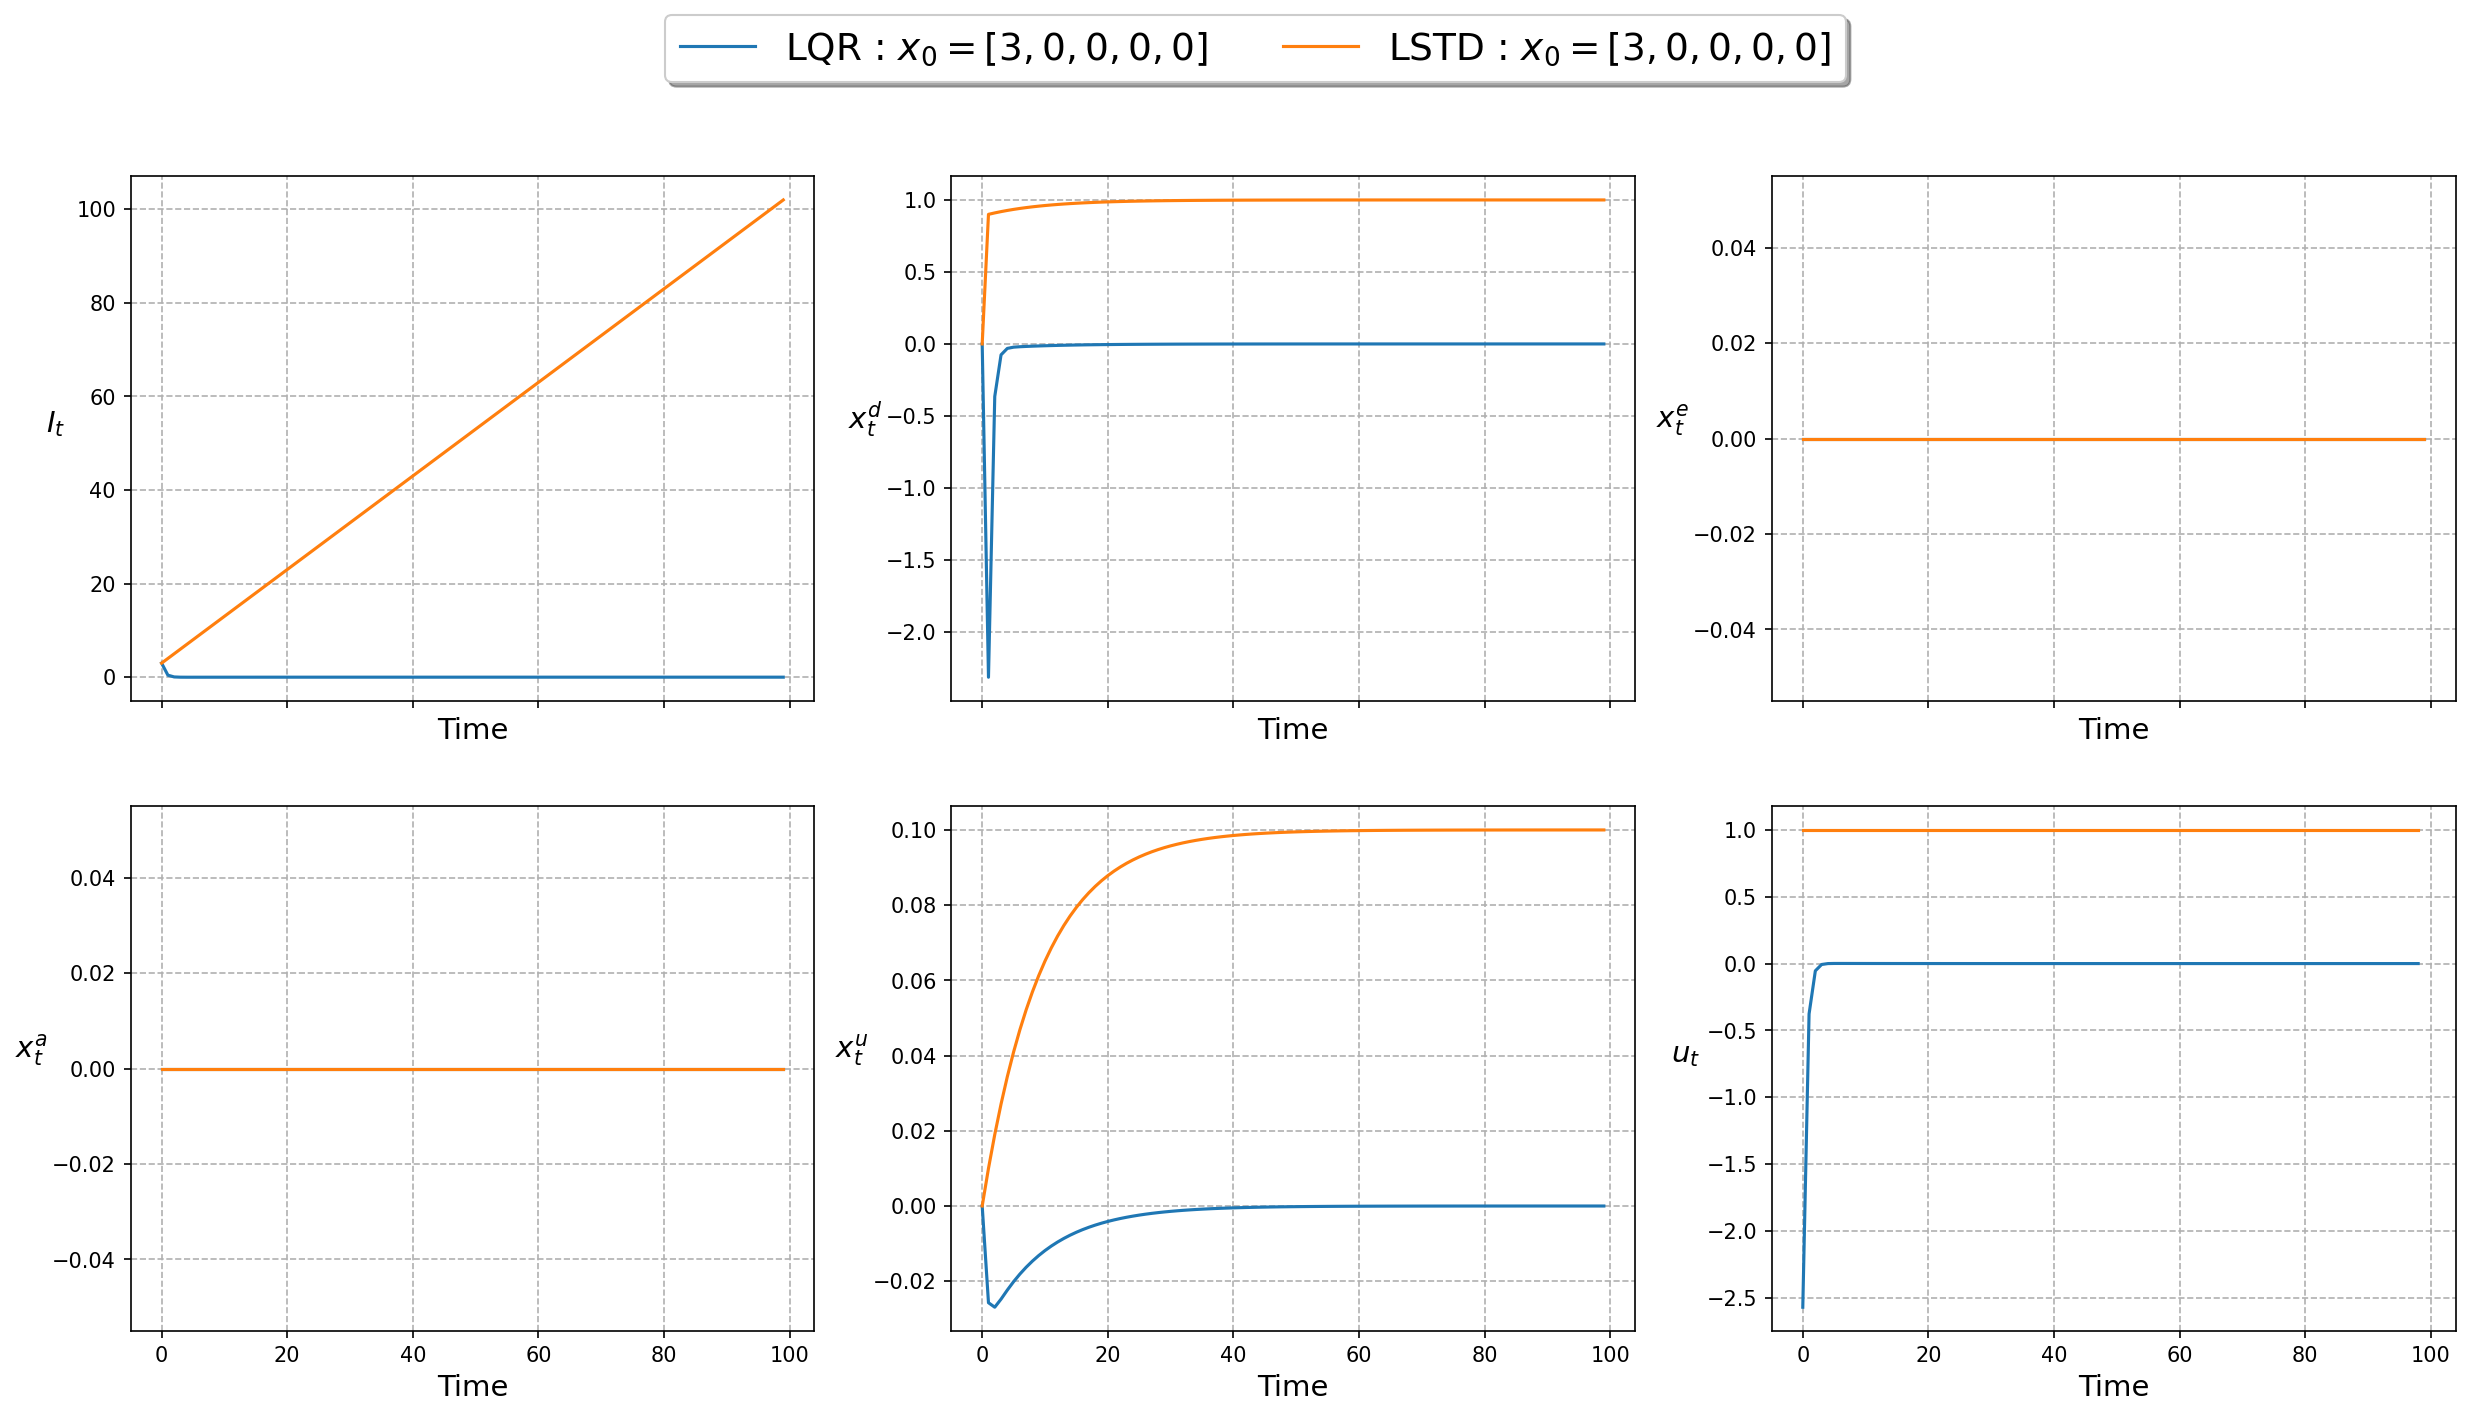

In [ ]:
x0 = [3, 0, 0, 0, 0]
n_step = 100
x_traj_LQR, u_traj_LQR = simulate_linear_model(x0, LQR_policy, n_step = n_step)
x_traj_lstd, u_traj_lstd = simulate_linear_model(x0, policy_lstd, n_step = n_step)


costs_lstd = sum([cost(x_traj_lstd[:,i], u_traj_lstd[:,i]) for i in range(n_step-1)])
cost_LQR = sum([cost(x_traj_LQR[:,i], u_traj_LQR[:,i]) for i in range(n_step-1)])

print(f"Costs LSTD: {costs_lstd}")
print(f"Costs LQR: {cost_LQR}")

show_trajectories([[x_traj_LQR], [x_traj_lstd]], [[u_traj_LQR], [u_traj_lstd]], [x0, x0], legend_labels=["LQR", "LSTD"])

># Q(λ)-learning


Define the basis function

In [ ]:
psi = generate_psi_functions(2, 5)
zeta0 = generate_psi_functions(2, 5)
zeta0 += [lambda x, u: 0] * (len(psi) - len(zeta0)) # pad with zeros to match the length of psi

In [ ]:
theta_qlearning = q_learning(
    lam = 0.1, 
    data= data_linear,
    step_size= lambda n: 1/n,
    theta0=np.ones(len(zeta0)),
    zeta0=zeta0,
    psi=psi,
    cost=cost,
    action_space=np.concatenate((np.linspace(0, 1, 100), np.linspace(-1, 0, 100,  endpoint=False)))
)

Q_qlearning = lambda x, u : np.array(theta_qlearning @ psi_vector(x, u))

KeyboardInterrupt: 

In [ ]:
action_space = np.concatenate((np.linspace(0, 1, 1000), np.linspace(-1, 0, 1000,  endpoint=False)))

def policy_qlearning(x: np.ndarray) -> np.ndarray:
    return action_space[np.argmin([Q_qlearning(x, a) for a in action_space])]

Costs Q-learning: 241077.53501396728
Costs LQR: 1.6672594432027763


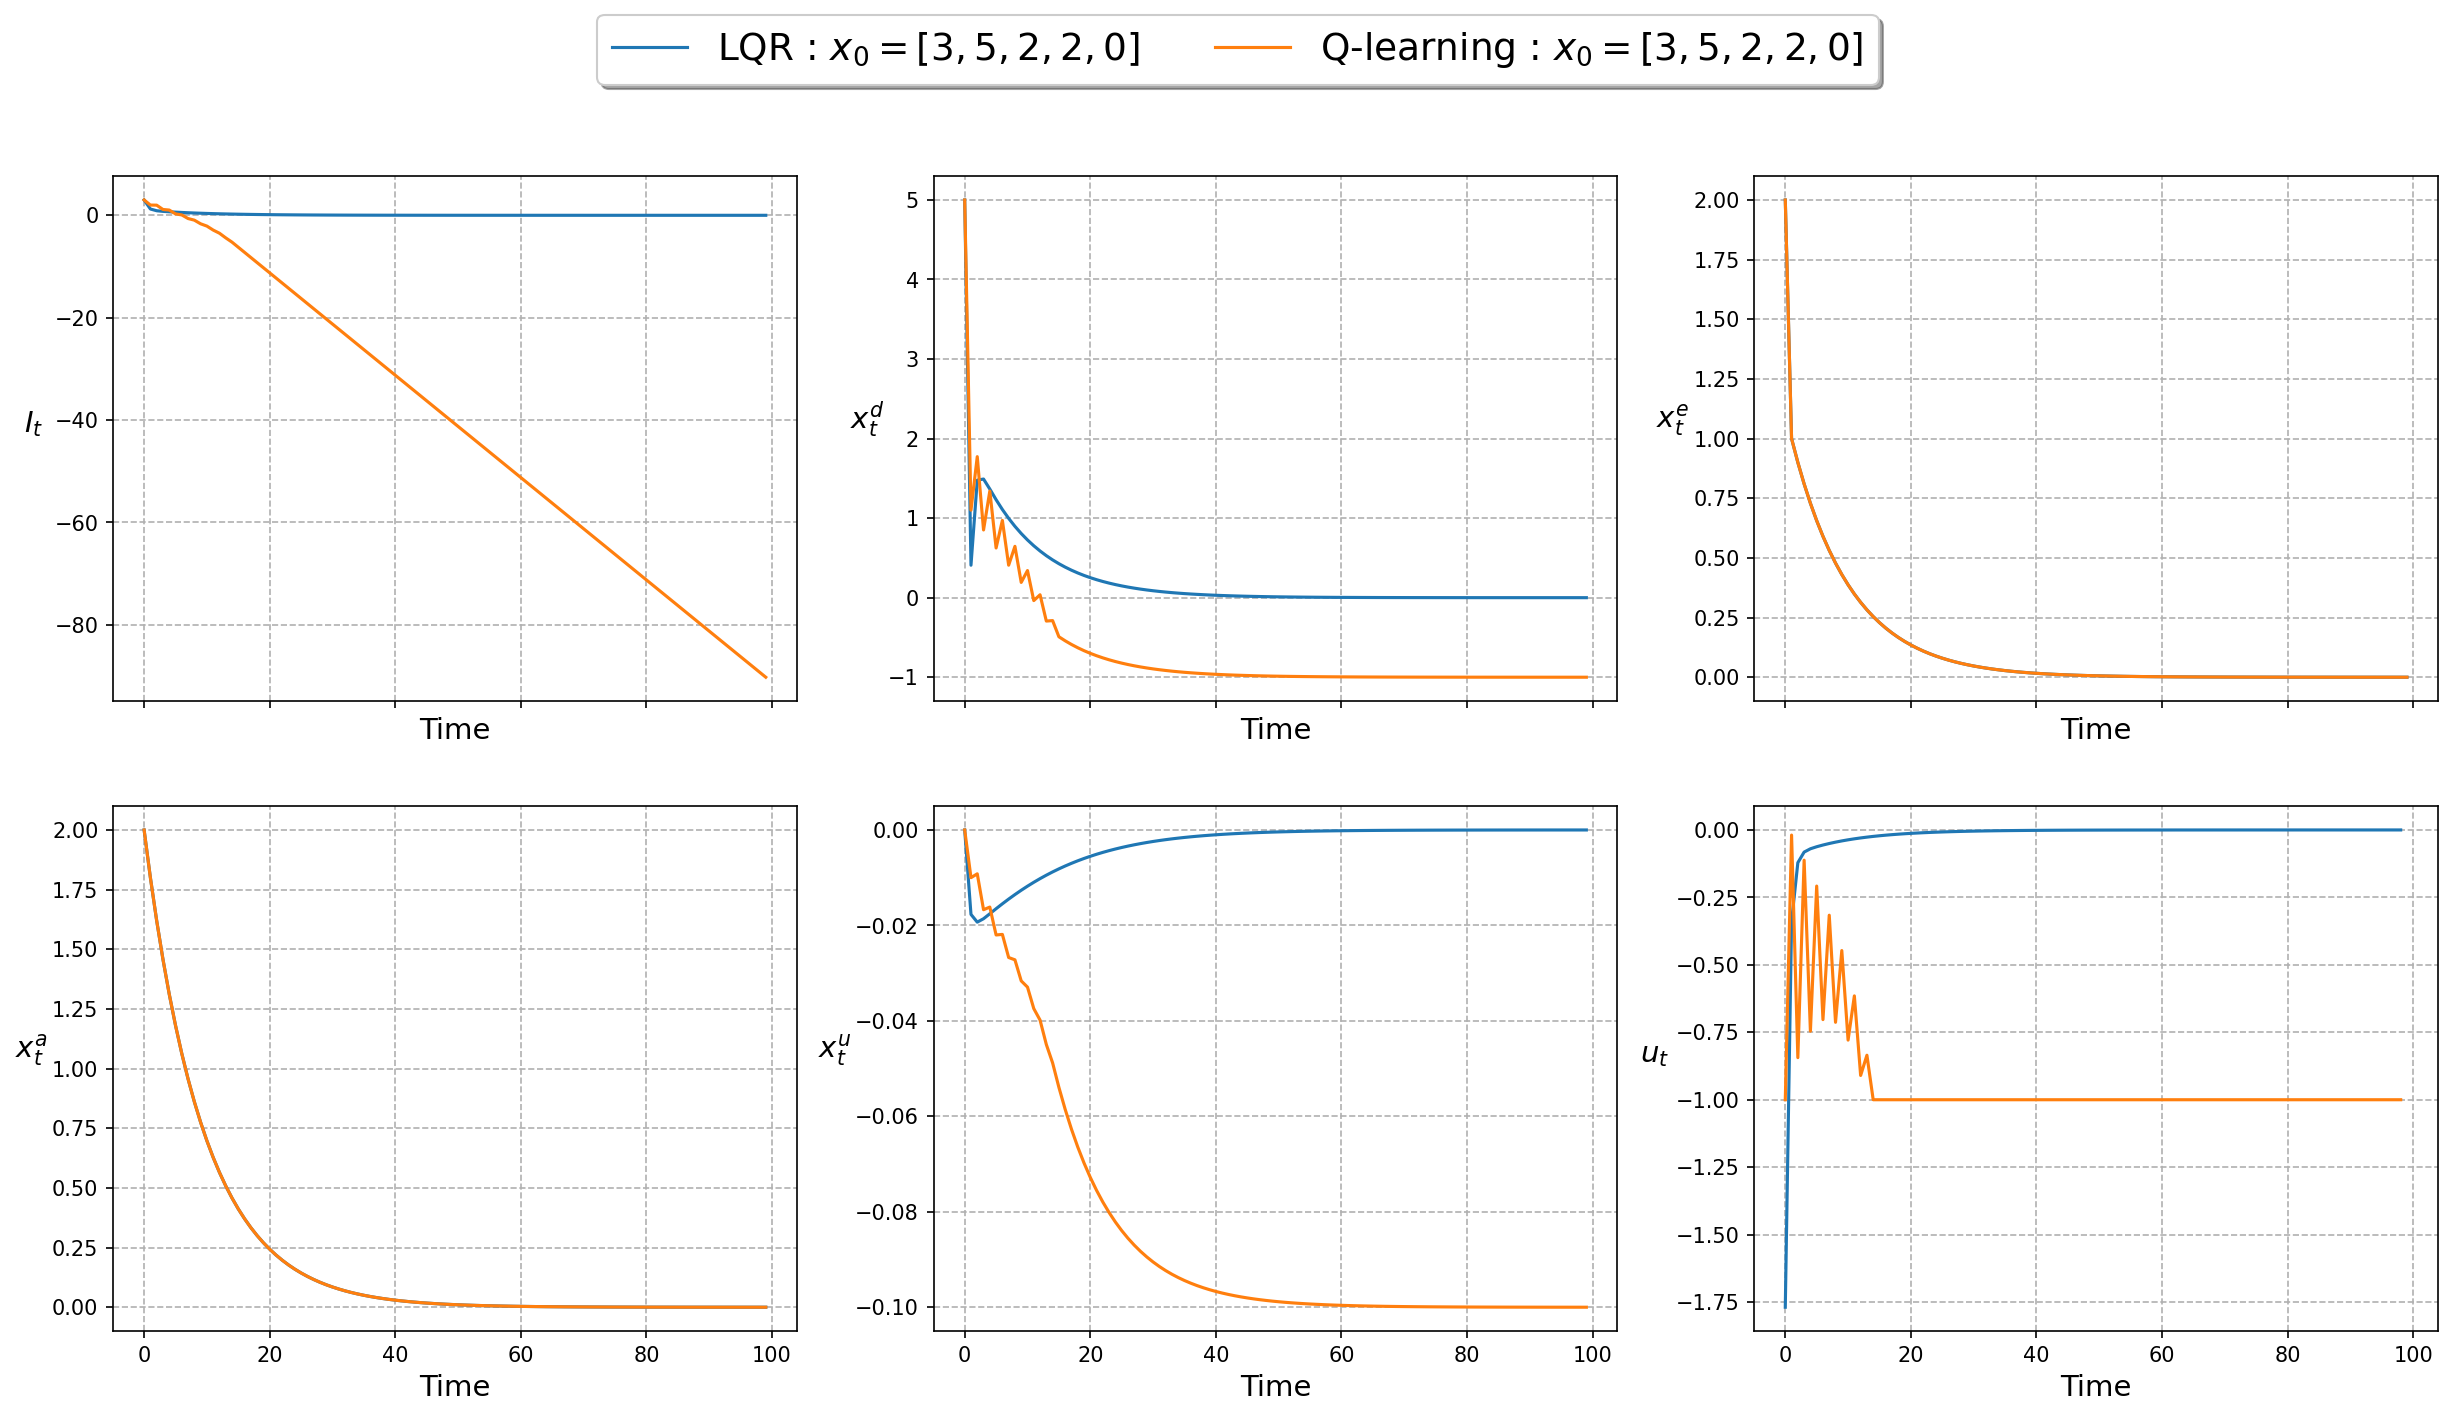

In [ ]:
x0 = [3, 5, 2, 2, 0]
n_step = 100

x_traj_ql, u_traj_ql = simulate_linear_model(x0, policy_qlearning, n_step = n_step)
x_traj_LQR, u_traj_LQR = simulate_linear_model(x0, LQR_policy, n_step = n_step)

cost_ql= sum([cost(x_traj_ql[:,i], u_traj_ql[:,i]) for i in range(n_step-1)])
cost_LQR = sum([cost(x_traj_LQR[:,i], u_traj_LQR[:,i]) for i in range(n_step-1)])


print(f"Costs Q-learning: {cost_ql}")
print(f"Costs LQR: {cost_LQR}")

show_trajectories([[x_traj_LQR], [x_traj_ql]], [[u_traj_LQR], [u_traj_ql]], [x0, x0], legend_labels=["LQR", "Q-learning"])